In [151]:
from pyspark.sql import SparkSession
import pyspark.sql as pysparksql
import pandas 
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")

In [152]:
#Creating SparkSession and also loading the csv data
spark=SparkSession.builder.appName("HeartStroke").getOrCreate()
heart_stroke_train=spark.read.csv("train_2v.csv",inferSchema=True,header=True)

In [153]:
#Printing the schema 
heart_stroke_train.printSchema()

root
 |-- id: integer (nullable = true)
 |-- gender: string (nullable = true)
 |-- age: double (nullable = true)
 |-- hypertension: integer (nullable = true)
 |-- heart_disease: integer (nullable = true)
 |-- ever_married: string (nullable = true)
 |-- work_type: string (nullable = true)
 |-- Residence_type: string (nullable = true)
 |-- avg_glucose_level: double (nullable = true)
 |-- bmi: double (nullable = true)
 |-- smoking_status: string (nullable = true)
 |-- stroke: integer (nullable = true)



In [154]:
#Printing the dimensions of the dataset(rows,columns)
heart_stroke_train.count(),len(heart_stroke_train.columns)

(43400, 12)

In [155]:
heart_stroke_train.show()

+-----+------+----+------------+-------------+------------+-------------+--------------+-----------------+----+---------------+------+
|   id|gender| age|hypertension|heart_disease|ever_married|    work_type|Residence_type|avg_glucose_level| bmi| smoking_status|stroke|
+-----+------+----+------------+-------------+------------+-------------+--------------+-----------------+----+---------------+------+
|30669|  Male| 3.0|           0|            0|          No|     children|         Rural|            95.12|18.0|           null|     0|
|30468|  Male|58.0|           1|            0|         Yes|      Private|         Urban|            87.96|39.2|   never smoked|     0|
|16523|Female| 8.0|           0|            0|          No|      Private|         Urban|           110.89|17.6|           null|     0|
|56543|Female|70.0|           0|            0|         Yes|      Private|         Rural|            69.04|35.9|formerly smoked|     0|
|46136|  Male|14.0|           0|            0|         

In [156]:
heart_stroke_train.groupBy('stroke').count().show()

+------+-----+
|stroke|count|
+------+-----+
|     1|  783|
|     0|42617|
+------+-----+



In [157]:
heart_stroke_train.createOrReplaceTempView('heart')

+-------------+-----+
|    work_type|count|
+-------------+-----+
|      Private|  441|
|Self-employed|  251|
|     Govt_job|   89|
|     children|    2|
+-------------+-----+



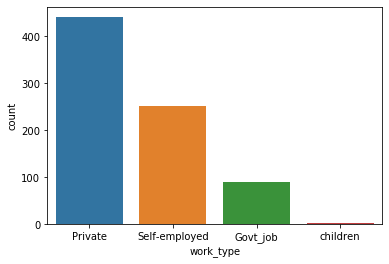

In [158]:
#We are finding which work type is more harmful. We are can see that people in private Jobs have more strokes 
heart_stroke_train.filter(heart_stroke_train['stroke']==1).groupBy('work_type').count().orderBy('count',ascending=False).show()
heart_stroke_train_plot=heart_stroke_train.filter(heart_stroke_train['stroke']==1).groupBy('work_type').count().orderBy('count',ascending=False)
sns.barplot(x='work_type',y='count',data=heart_stroke_train_plot.toPandas())

In [159]:
heart_stroke_train.filter(heart_stroke_train['stroke']==1).groupBy('smoking_status').count().orderBy('count',ascending=False).show()


+---------------+-----+
| smoking_status|count|
+---------------+-----+
|   never smoked|  284|
|formerly smoked|  221|
|           null|  145|
|         smokes|  133|
+---------------+-----+



Since we can see that we have the 'null' value in the smoke type. It will be better to replace it another parameter called 'No Info' as it will look cleaner

In [160]:
updated_info=heart_stroke_train.fillna('No Info',subset=['smoking_status'])
updated_info.show()

+-----+------+----+------------+-------------+------------+-------------+--------------+-----------------+----+---------------+------+
|   id|gender| age|hypertension|heart_disease|ever_married|    work_type|Residence_type|avg_glucose_level| bmi| smoking_status|stroke|
+-----+------+----+------------+-------------+------------+-------------+--------------+-----------------+----+---------------+------+
|30669|  Male| 3.0|           0|            0|          No|     children|         Rural|            95.12|18.0|        No Info|     0|
|30468|  Male|58.0|           1|            0|         Yes|      Private|         Urban|            87.96|39.2|   never smoked|     0|
|16523|Female| 8.0|           0|            0|          No|      Private|         Urban|           110.89|17.6|        No Info|     0|
|56543|Female|70.0|           0|            0|         Yes|      Private|         Rural|            69.04|35.9|formerly smoked|     0|
|46136|  Male|14.0|           0|            0|         

We can now see that we null value in the smoking_status column has been replaced with No Info.

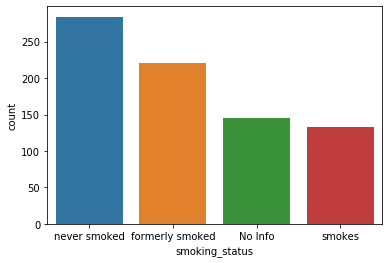

In [161]:
smoking_status_plot=updated_info.filter(heart_stroke_train['stroke']==1).groupBy('smoking_status').count().orderBy('count',ascending=False)
sns.barplot(x='smoking_status',y='count',data=smoking_status_plot.toPandas())

We can see that people who have never smoked have higher risk of heart_stroke

+----+-----+
| age|count|
+----+-----+
|82.0|   36|
|81.0|   43|
|80.0|   49|
|79.0|   70|
|78.0|   57|
|77.0|   24|
|76.0|   24|
|75.0|   23|
|74.0|   24|
|73.0|   15|
|72.0|   21|
|71.0|   19|
|70.0|   25|
|69.0|   20|
|68.0|   20|
|67.0|   23|
|66.0|   17|
|65.0|   18|
|64.0|    8|
|63.0|   18|
+----+-----+
only showing top 20 rows



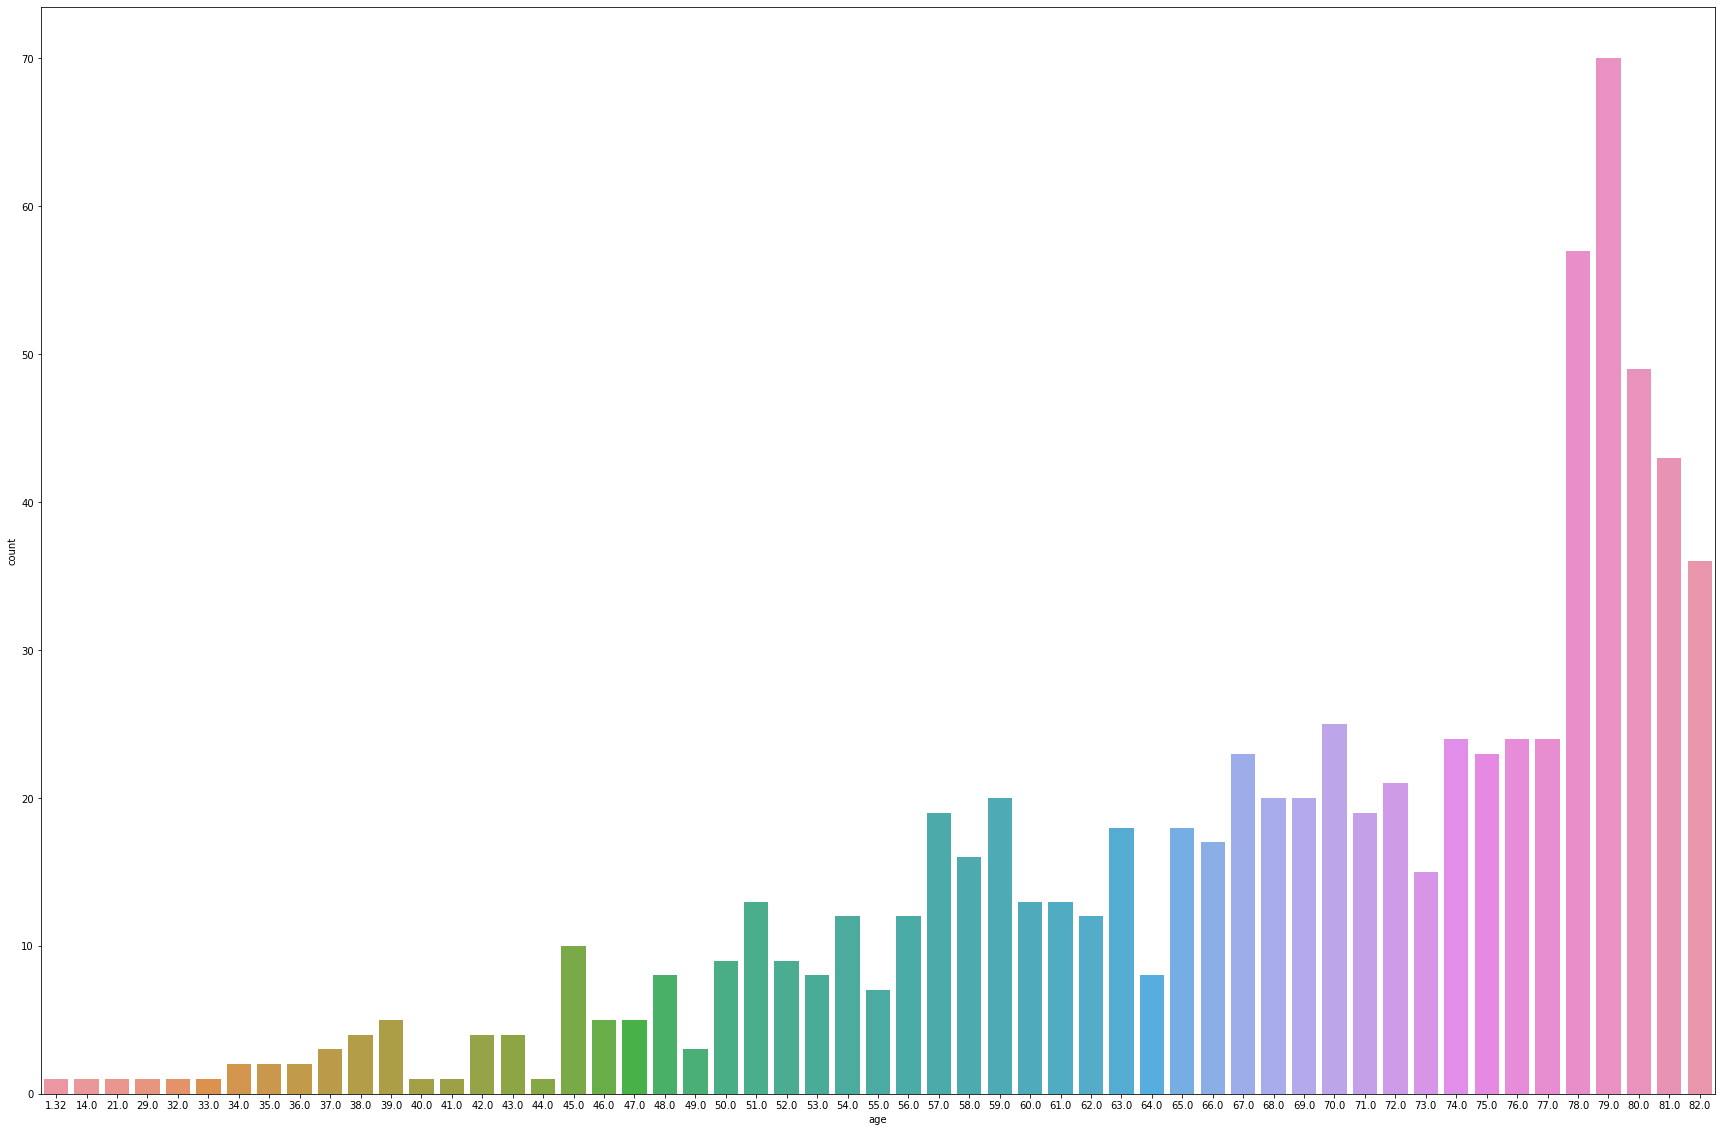

In [162]:
import matplotlib.pyplot as plt
%matplotlib inline
updated_info.filter(updated_info['stroke']==1).groupBy('age').count().orderBy('age',ascending=False).show()
plt.figure(figsize=(30, 20))
sns.barplot(x='age',y='count',data=updated_info.filter(updated_info['stroke']==1).groupBy('age').count().orderBy('age',ascending=False).toPandas())

In [163]:
updated_info.filter(updated_info['stroke']==1).select('bmi').show()

+----+
| bmi|
+----+
|36.6|
|null|
|32.5|
|34.4|
|24.0|
|29.0|
|27.4|
|22.8|
|null|
|24.2|
|29.7|
|36.8|
|27.3|
|null|
|28.2|
|30.9|
|37.5|
|25.8|
|37.8|
|null|
+----+
only showing top 20 rows



We can see that there is null value in the bmi column. In the following cell we will be replacing this with mean value in the column. This is part of the data cleaning task.

In [164]:
from pyspark.sql.functions import mean
mean = updated_info.select(mean(updated_info['bmi'])).collect()
mean_bmi = mean[0][0]
updated_info = updated_info.fillna(mean_bmi,['bmi'])
updated_info.filter(updated_info['stroke']==1).select('bmi').show()

+------------------+
|               bmi|
+------------------+
|              36.6|
|28.605038390004545|
|              32.5|
|              34.4|
|              24.0|
|              29.0|
|              27.4|
|              22.8|
|28.605038390004545|
|              24.2|
|              29.7|
|              36.8|
|              27.3|
|28.605038390004545|
|              28.2|
|              30.9|
|              37.5|
|              25.8|
|              37.8|
|28.605038390004545|
+------------------+
only showing top 20 rows



In [165]:
import pyspark.sql.functions as func
updated_info = updated_info.withColumn('bmi', func.round(updated_info['bmi'], 1))
updated_info.filter(updated_info['stroke']==1).select('bmi').show()

+----+
| bmi|
+----+
|36.6|
|28.6|
|32.5|
|34.4|
|24.0|
|29.0|
|27.4|
|22.8|
|28.6|
|24.2|
|29.7|
|36.8|
|27.3|
|28.6|
|28.2|
|30.9|
|37.5|
|25.8|
|37.8|
|28.6|
+----+
only showing top 20 rows



In [166]:
spark.sql("SELECT * FROM heart WHERE bmi=28.6").count()

241

Now we will be able to see the effect of BMI in the number of people who get the heart stroke. 

In [167]:
updated_info.filter(updated_info['stroke']==1).groupBy('bmi').count().orderBy('count',ascending=False).show()

+----+-----+
| bmi|count|
+----+-----+
|28.6|  143|
|26.4|    9|
|31.4|    9|
|30.9|    9|
|26.6|    9|
|27.5|    8|
|30.7|    8|
|31.5|    8|
|24.2|    7|
|25.8|    7|
|28.5|    7|
|28.0|    6|
|29.3|    6|
|27.3|    6|
|30.3|    6|
|27.7|    6|
|30.6|    6|
|29.7|    6|
|27.0|    6|
|25.0|    6|
+----+-----+
only showing top 20 rows



We can see that people with people with higher BMI chance of getting a stroke.

In the next section we will see how many people had participated in this clinical process

In [168]:
spark.sql("SELECT gender,count(gender) as gender_count,count(gender)*100/sum(count(gender)) over() as percentage FROM heart GROUP BY gender").show()

+------+------------+-------------------+
|gender|gender_count|         percentage|
+------+------------+-------------------+
|Female|       25665|  59.13594470046083|
| Other|          11|0.02534562211981567|
|  Male|       17724|  40.83870967741935|
+------+------------+-------------------+



In [169]:
updated_info.filter((updated_info['stroke'] == 1) & (updated_info['age'] > '50')).count()

708

In [170]:
#StringIndexer for gender column
from pyspark.ml.feature import StringIndexer
from pyspark.ml.feature import OneHotEncoderEstimator
gender_indexer=StringIndexer(inputCol="gender",outputCol="gender_num")
updated_info=gender_indexer.fit(updated_info).transform(updated_info)
updated_info.select(["gender","gender_num"]).show(5)

+------+----------+
|gender|gender_num|
+------+----------+
|  Male|       1.0|
|  Male|       1.0|
|Female|       0.0|
|Female|       0.0|
|  Male|       1.0|
+------+----------+
only showing top 5 rows



In [171]:
#OneHotEncoderEstimate for the gender column
gender_encoder=OneHotEncoderEstimator(inputCols=["gender_num"],outputCols=["gender_num_vec"])
model=gender_encoder.fit(updated_info)
updated_info=model.transform(updated_info)
updated_info.select("gender_num_vec").take(5)

[Row(gender_num_vec=SparseVector(2, {1: 1.0})),
 Row(gender_num_vec=SparseVector(2, {1: 1.0})),
 Row(gender_num_vec=SparseVector(2, {0: 1.0})),
 Row(gender_num_vec=SparseVector(2, {0: 1.0})),
 Row(gender_num_vec=SparseVector(2, {1: 1.0}))]

In [172]:
#StringIndexer for ever married column
ever_married_indexer=StringIndexer(inputCol="ever_married",outputCol="ever_married_num")
updated_info=ever_married_indexer.fit(updated_info).transform(updated_info)
updated_info.select(["ever_married","ever_married_num"]).show(5)

+------------+----------------+
|ever_married|ever_married_num|
+------------+----------------+
|          No|             1.0|
|         Yes|             0.0|
|          No|             1.0|
|         Yes|             0.0|
|          No|             1.0|
+------------+----------------+
only showing top 5 rows



In [173]:
#OneHotEncoder for ever married column
ever_married_encoder=OneHotEncoderEstimator(inputCols=["ever_married_num"],outputCols=["ever_married_num_vec"])
model=ever_married_encoder.fit(updated_info)
updated_info=model.transform(updated_info)
updated_info.select("ever_married_num_vec").take(5)

[Row(ever_married_num_vec=SparseVector(1, {})),
 Row(ever_married_num_vec=SparseVector(1, {0: 1.0})),
 Row(ever_married_num_vec=SparseVector(1, {})),
 Row(ever_married_num_vec=SparseVector(1, {0: 1.0})),
 Row(ever_married_num_vec=SparseVector(1, {}))]

In [174]:
#StringIndexer for work_type column
work_type_indexer=StringIndexer(inputCol="work_type",outputCol="work_type_num")
updated_info=work_type_indexer.fit(updated_info).transform(updated_info)
updated_info.select(["work_type","work_type_num"]).show(5)

+------------+-------------+
|   work_type|work_type_num|
+------------+-------------+
|    children|          2.0|
|     Private|          0.0|
|     Private|          0.0|
|     Private|          0.0|
|Never_worked|          4.0|
+------------+-------------+
only showing top 5 rows



In [175]:
#OneHotEncoder for work_type
work_type_encoder=OneHotEncoderEstimator(inputCols=["work_type_num"],outputCols=["work_type_num_vec"])
model=work_type_encoder.fit(updated_info)
updated_info=model.transform(updated_info)
updated_info.select("work_type_num_vec").take(5)

[Row(work_type_num_vec=SparseVector(4, {2: 1.0})),
 Row(work_type_num_vec=SparseVector(4, {0: 1.0})),
 Row(work_type_num_vec=SparseVector(4, {0: 1.0})),
 Row(work_type_num_vec=SparseVector(4, {0: 1.0})),
 Row(work_type_num_vec=SparseVector(4, {}))]

In [176]:
Residence_type_indexer=StringIndexer(inputCol="Residence_type",outputCol="Residence_type_num")
updated_info=Residence_type_indexer.fit(updated_info).transform(updated_info)
updated_info.select(["Residence_type","Residence_type_num"]).show(5)

+--------------+------------------+
|Residence_type|Residence_type_num|
+--------------+------------------+
|         Rural|               1.0|
|         Urban|               0.0|
|         Urban|               0.0|
|         Rural|               1.0|
|         Rural|               1.0|
+--------------+------------------+
only showing top 5 rows



In [177]:
Residence_type_encoder=OneHotEncoderEstimator(inputCols=["Residence_type_num"],outputCols=["Residence_type_num_vec"])
model=Residence_type_encoder.fit(updated_info)
updated_info=model.transform(updated_info)
updated_info.select("Residence_type_num_vec").take(5)

[Row(Residence_type_num_vec=SparseVector(1, {})),
 Row(Residence_type_num_vec=SparseVector(1, {0: 1.0})),
 Row(Residence_type_num_vec=SparseVector(1, {0: 1.0})),
 Row(Residence_type_num_vec=SparseVector(1, {})),
 Row(Residence_type_num_vec=SparseVector(1, {}))]

In [178]:
smoking_status_indexer=StringIndexer(inputCol="smoking_status",outputCol="smoking_status_num")
updated_info=smoking_status_indexer.fit(updated_info).transform(updated_info)
updated_info.select(["smoking_status","smoking_status_num"]).show(5)

+---------------+------------------+
| smoking_status|smoking_status_num|
+---------------+------------------+
|        No Info|               1.0|
|   never smoked|               0.0|
|        No Info|               1.0|
|formerly smoked|               2.0|
|        No Info|               1.0|
+---------------+------------------+
only showing top 5 rows



In [179]:
smoking_status_encoder=OneHotEncoderEstimator(inputCols=["smoking_status_num"],outputCols=["smoking_status_num_vec"])
model=smoking_status_encoder.fit(updated_info)
updated_info=model.transform(updated_info)
updated_info.select("smoking_status_num_vec").take(5)

[Row(smoking_status_num_vec=SparseVector(3, {1: 1.0})),
 Row(smoking_status_num_vec=SparseVector(3, {0: 1.0})),
 Row(smoking_status_num_vec=SparseVector(3, {1: 1.0})),
 Row(smoking_status_num_vec=SparseVector(3, {2: 1.0})),
 Row(smoking_status_num_vec=SparseVector(3, {1: 1.0}))]

We are now going apply vectorAssembler to take all the attributes in the dataframe and combine it into one single output feature.This is mentioned in the outputCol parameter.

In [180]:
from pyspark.ml.linalg import Vectors
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.feature import StandardScaler

assembler=VectorAssembler(inputCols=['id','age','hypertension','heart_disease','ever_married_num_vec','work_type_num_vec','Residence_type_num_vec'
                                     ,'avg_glucose_level','bmi','smoking_status_num_vec','stroke',],outputCol="features")
updated_info=assembler.transform(updated_info)
scaler = StandardScaler(inputCol="features", outputCol="scaledFeatures",withMean=True,withStd=True)

scalerModel = scaler.fit(updated_info)
scaledHousing = scalerModel.transform(updated_info)
scaledHousing.select(["features", "scaledFeatures"]).show(5)


+--------------------+--------------------+
|            features|      scaledFeatures|
+--------------------+--------------------+
|(16,[0,1,7,10,11,...|[-0.2684655533322...|
|(16,[0,1,2,4,5,9,...|[-0.2780042166500...|
|(16,[0,1,5,9,10,1...|[-0.9397786443458...|
|(16,[0,1,4,5,10,1...|[0.95941193266286...|
|(16,[0,1,10,11,13...|[0.46553696177507...|
+--------------------+--------------------+
only showing top 5 rows



In [181]:
#Splitting the Data into 2 sets
trainSet,testSet=scaledHousing.randomSplit([0.8,0.2])

Applying the machine learnings models in the Dataset. The following models are implemented as given below
1.Logistic Regression
2.Decision Tree Regression
3.RandomForest Regression

Before implementing the 